1. x Test daten abspeichern und hier einlesen
2. x Ereigniskenndaten einlesen von csv
3. x zu den listenobjekten jeweils eventdaten hinzufügen (Dauer, hN, imax_60, Jährlichkeit)
4. Benchmark eventsauswählen
5. x load in_scaler und out_scaler
6. x testdaten sequenzieren und normalisieren
7. daten vorhersagen
8. Auswahl plotten mit delta time
    - wie plotten? evtl niederschlag mit balken von oben und predictions + actual ganglinie von unten
    - ereigniss kenndaten angeben (Dauer, hN, imax_60, Jährlichkeit)
9. x Scatterplot mit Evendaten

Auswertung aller Sequencen
- MAE
- RMSE
- Scatterplott Actual vs Fitted
- Boxplot mit quantilen für jeden Vorhersagezeitschritt
- siehe Plots burrichter




In [1]:
# Load Relevant Libraries, the model and the test data
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from tensorflow.keras.models import model_from_json
import joblib
import pickle
import os
from modules.sequence_and_normalize import sequence_data, sequence_sample_random, sequence_list
from sklearn.preprocessing import MinMaxScaler


# Assign all relevant paths
model_folder = '05_models\\Gievenbeck_SingleNode_LSTM_20240328'
model_name = "Gievenbeck_SingleNode_LSTM_20240328"
model_path = os.path.join(model_folder, f'{model_name}.json')
weights_path = os.path.join(model_folder, f'{model_name}.weights.h5')
in_scaler_path = os.path.join(model_folder, 'in_scaler.pkl')
out_scaler_path = os.path.join(model_folder, 'out_scaler.pkl')
test_data_path = os.path.join(model_folder, 'test_data')
# Saving model design to JSON

# load json and create model
json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(weights_path)

# Load the scalers
in_scaler = joblib.load(in_scaler_path)
out_scaler = joblib.load(out_scaler_path)

# Load the test data
with open(test_data_path, 'rb') as file:
    test_data = pickle.load(file)

print("Loaded model from disk")

Loaded model from disk


In [2]:
# Load events data
events_df = pd.read_csv('02_input_data/events_FMO.csv')

# sequence data to list structure
lag = int(3 * 60 / 5)
delay = 0
p_steps = 6

in_col=['duration', 'p']
out_col=['Q_out']

seq_test, seq_test_trans = sequence_list(test_data, in_vars=in_col, out_vars=out_col, in_scaler=in_scaler, 
                                  out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)


In [3]:
# Print all Event meta data 
i=0
for obj in seq_test_trans:
    print(i, obj[0])
    i += 1


0 {'name': 'Gievenbeck_2016-02-22 03 40 00_hN12 65', 'duration': 765, 'total precipitation': 12.649992823600769, 'max intensity': 15.83999605178833, 'interval': 5, 'Ereignis': 'Aufgezeichnet'}
1 {'name': 'Gievenbeck_2014-07-24 13 45 00_hN11 22', 'duration': 310, 'total precipitation': 11.21999523540338, 'max intensity': 54.143999862670896, 'interval': 5, 'Ereignis': 'Aufgezeichnet'}
2 {'name': 'Gievenbeck_e2_T20D20', 'duration': 255, 'total precipitation': 24.099995930989582, 'max intensity': 156.2400100708008, 'interval': 5, 'Ereignis': 'Euler Typ 2'}
3 {'name': 'Gievenbeck_e2_T3D90', 'duration': 325, 'total precipitation': 23.0799986521403, 'max intensity': 94.72800750732422, 'interval': 5, 'Ereignis': 'Euler Typ 2'}
4 {'name': 'Gievenbeck_e2_T3D1440', 'duration': 1675, 'total precipitation': 47.109984089930855, 'max intensity': 93.36000716686249, 'interval': 5, 'Ereignis': 'Euler Typ 2'}
5 {'name': 'Gievenbeck_e2_T2D540', 'duration': 775, 'total precipitation': 32.54998461405436, 'm

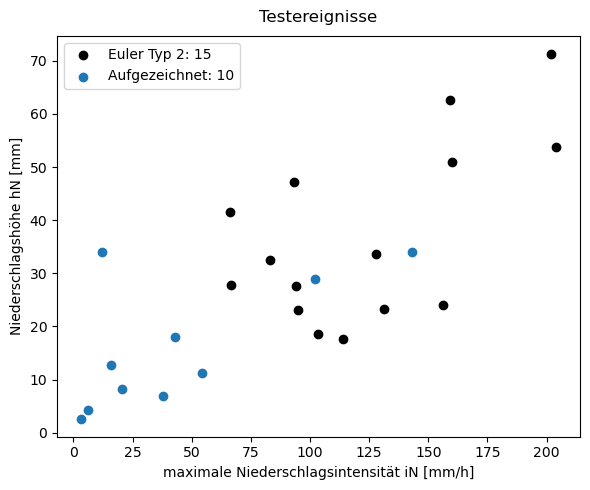

In [4]:
# Extract total precipitation and max intensity from seq_test
e2_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['Ereignis'] == 'Euler Typ 2']
e2_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['Ereignis'] == 'Euler Typ 2']

aufgezeichnet_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['Ereignis'] == 'Aufgezeichnet']
aufgezeichnet_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['Ereignis'] == 'Aufgezeichnet']

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.plot( e2_intensity, e2_precipitation,'o', color='black', label='Sample')
ax2.scatter(aufgezeichnet_intensity, aufgezeichnet_precipitation, marker='o',  label='Events')

ax2.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Testereignisse', pad=10)
ax2.legend(labels=['Euler Typ 2: {}'.format(len(e2_precipitation)), 'Aufgezeichnet: {}'.format(len(aufgezeichnet_precipitation))])
plt.tight_layout()


In [5]:
# in_col=1
# out_col=2
# # Keep track of original shapes of in and out data
# in_original_shape = [sample[in_col].shape for sample in seq_test]  
# in_concat = np.concatenate([np.array(sample[in_col]) for sample in seq_test])
# in_concat = np.concatenate([np.array(sequence) for sequence in in_concat])
# # in_concat_flattened = np.reshape(in_concat, (in_concat.shape[0], -1, in_concat.shape[2]))

# out_original_shape = [sample[out_col].shape for sample in seq_test]

# out_concat = np.concatenate([sample[2].reshape(sample[2].shape[0], -1) for sample in seq_test])

# # out_concat = np.concatenate([np.array(sample[out_col]) for sample in seq_test])

# print(in_concat)

# in_invert = in_scaler.inverse_transform(in_concat)
# out_invert = out_scaler.inverse_transform(out_concat)



In [6]:
# # Reshape in_concat back to original shape
# in_invert = np.split(in_concat, np.cumsum([np.prod(shape) for shape in in_original_shape[:-1]]))
# in_invert = [sample.reshape(shape) for sample, shape in zip(in_invert, in_original_shape)]


# # Reshape out_concat back to original shape
# out_invert = np.split(out_concat, np.cumsum([np.prod(shape) for shape in out_original_shape[:-1]]))
# out_invert = [sample.reshape(shape) for sample, shape in zip(out_invert, out_original_shape)]

# seq_test_invert = [(seq_test[i][0], in_invert[i], out_invert[i]) for i in range(len(seq_test))]

# # # Check if the sum of the columns is the same to verify reshaping works properly
# # col_1_sum_seq_test_invert = sum([np.sum(sample[1]) for sample in seq_test_invert])
# # col_1_sum_seq_test = sum([np.sum(sample[1]) for sample in seq_test])
# # col_2_sum_seq_test_invert = sum([np.sum(sample[2]) for sample in seq_test_invert])
# # col_2_sum_seq_test = sum([np.sum(sample[2]) for sample in seq_test])
# # is_same_sum = col_1_sum_seq_test_invert == col_1_sum_seq_test
# # is_same_sum_2 = col_2_sum_seq_test_invert == col_2_sum_seq_test
# # print(is_same_sum, is_same_sum_2)


In [11]:
seq_test[1][1][1][:,0]

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110.,
       115., 120., 125., 130., 135., 140., 145., 150., 155., 160., 165.,
       170., 175., 180.])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


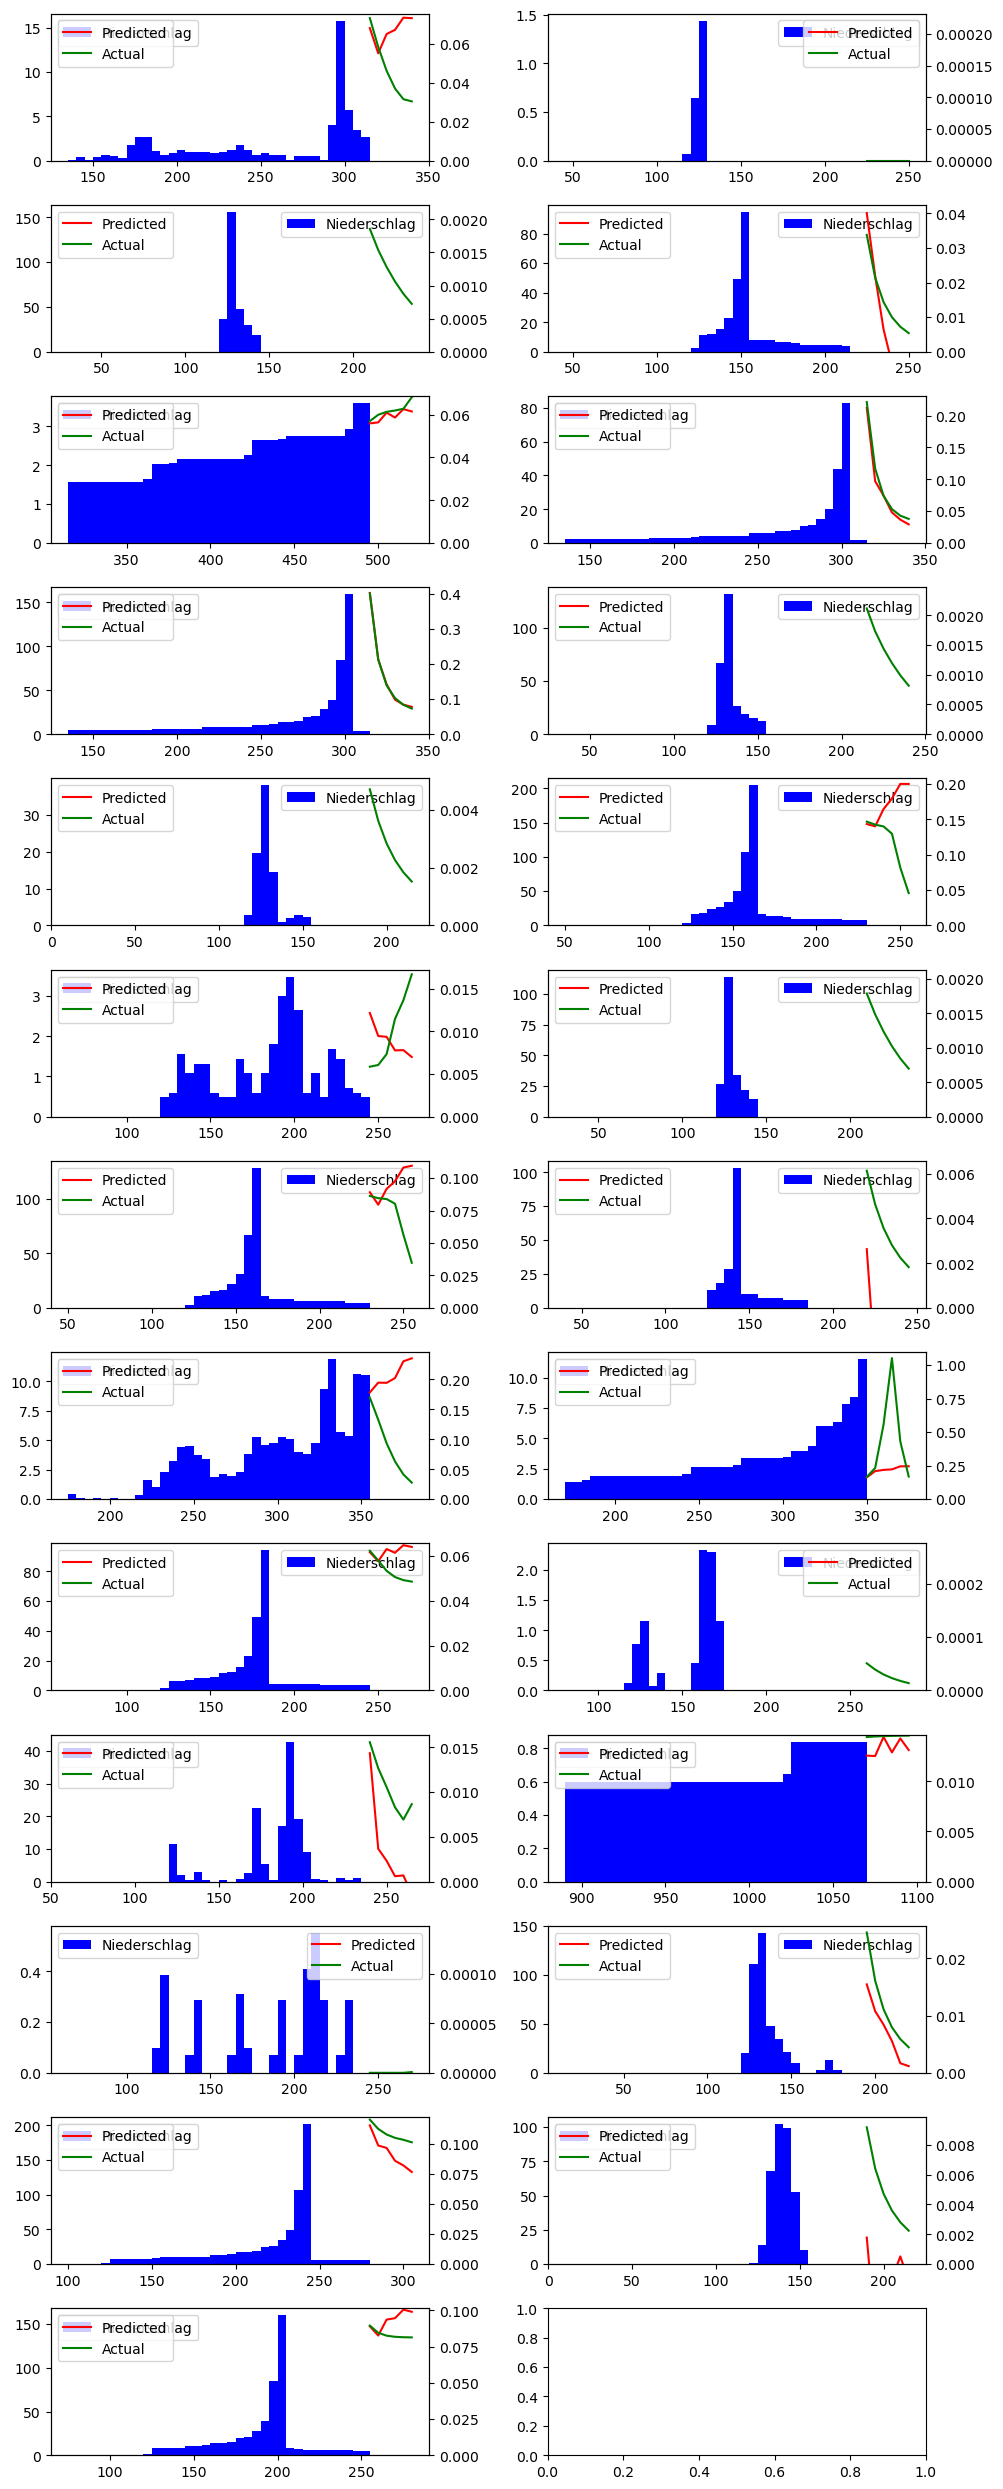

In [33]:
# Specify what the column index of the duration data in the input data is
duration_col = int(0)
#retrieve the interval of the time steps
interval = seq_test[0][0]['interval']  

# Create a grid of subplots
plot_rows = int(len(seq_test_trans)/2+1)
fig, axs = plt.subplots(plot_rows, 2, figsize=(10, 1*len(seq_test_trans)))

# Loop through n_sample
for n_sample in range(len(seq_test_trans)):
    # n = 12 +int((len(seq_test[n_sample][1])-24) / 3)
    n = int(len(seq_test[n_sample][1]) / 5)

    # Calculate the start and end time of the sequence so that a duration column can be created
    start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
    end_time = start_time + p_steps * interval
    duration_col = np.arange(start_time, end_time, interval)

    Predict = model.predict(seq_test_trans[n_sample][1])
    Predict_invert = out_scaler.inverse_transform(Predict)
    
    
    predict_seq = np.column_stack((duration_col,Predict_invert[n]))
    
    actual_seq = np.column_stack((duration_col,seq_test[n_sample][2][n]))
    # joined_cols = np.array((Predict_invert[n], seq_test[n_sample][2][n], seq_test[n_sample][1][n, :]))
    # new_array = np.column_stack((Predict_invert[n], seq_test[n_sample][2][n], seq_test[n_sample][1][n, :]))
    
    ''' 
    To do: - why is precipitation always min 1
        - change location of legends
        - change upper limit of precip
        - add lable for axis
        - add title
        - make it a function
        - precip axis left
    '''

    
    
    # Calculate column index for the subplot. Only important for plot!!
    col_index = n_sample % 2


    # Create Barplot of Precipitation
    ax1 = axs[n_sample // 2, col_index]
    x = seq_test[n_sample][1][n][:,0]  # Set x-axis values
    ax1.bar(x, seq_test[n_sample][1][n][:,1], color='blue', label='Niederschlag', width=interval, align='edge')
    # ax2.bar(seq_test[n_sample][1][n][:,1], color='blue', label='Niederschlag',height=1)
    ax1.set_ylim(bottom=0)  # Set y-axis to start from zero
    ax1.legend()

    # Create a twin axis on the right side
    # Plotting the predicted and actual values in the corresponding subplot
    ax2 = ax1.twinx()
    ax2.plot(predict_seq[:, 0], predict_seq[:, 1], color = 'red', label='Predicted')
    ax2.plot(actual_seq[:, 0], actual_seq[:, 1], color = 'green', label='Actual')
    ax2.set_ylim(bottom=0)  # Set y-axis to start from zero
    ax2.legend()


plt.tight_layout()

# Show the plot
plt.show()


In [17]:
y_revert[n]
Predict_revert

array([[ 1.0522663e-01,  5.7348918e-02,  5.4582451e-02,  4.8360631e-02,
         4.5133911e-02,  3.9728731e-02],
       [ 6.0810089e-02,  3.4321085e-02,  3.1196637e-02,  2.0356130e-02,
         1.4608675e-02,  1.0528478e-02],
       [ 3.1902459e-02,  1.9582804e-02,  1.6808270e-02,  1.0733405e-02,
         6.3077221e-03,  5.0414647e-03],
       [ 1.5446843e-02,  1.0771826e-02,  8.4250355e-03,  5.5546975e-03,
         1.6659563e-03,  1.1715094e-03],
       [ 7.4138250e-03,  5.0278418e-03,  3.4973994e-03,  2.8361194e-03,
         9.6795190e-04,  7.2162779e-06],
       [ 4.1670436e-03, -1.9513299e-04, -6.0929870e-04,  2.9348861e-04,
         5.0697580e-04, -8.3730405e-04],
       [ 2.4088321e-03, -2.5262409e-03, -2.6542724e-03, -1.7694602e-03,
        -9.4822736e-04, -2.4128256e-03],
       [ 6.3082075e-04, -3.3144972e-03, -3.1594553e-03, -2.3152500e-03,
        -1.3225762e-03, -2.6804756e-03],
       [-9.0354559e-04, -3.6638728e-03, -3.2704596e-03, -2.4295433e-03,
        -1.4432510e-03, 